# Lab 3: PCA Reconstruction Error & Gradient Descent Variants
**Datasets:** `advertising.csv`, `faa.csv`, `Housing.csv`  
**Goals**
1. Compute reconstruction error using PCA (as in the Eigenfaces paper) for n = [1,2,3,5,7,10,15].
2. Implement and compare: Simple Gradient Descent, Momentum GD, and Nesterov Accelerated GD (NAG) for linear regression on each dataset.

**Notes**
- If the assignment doesn't specify a target column, we'll choose the **last numeric column** as the target.
- Missing values are filled with column mean.
- Non-numeric columns will be dropped (we only use numeric features).
- For PCA we follow the paper: let X be data (rows = samples, cols = features). Let μ be column mean. A = X - μ. Compute eigenvectors of AᵀA (small matrix method). Compute reconstruction and error: ∑‖x_i - r_i‖².


In [6]:
# Cell 1: imports and utility functions
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import eig
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = (8,5)


## Utility functions
- `clean_and_load`: loads a CSV, keeps numeric columns, fills missing values with column mean.
- `choose_target`: picks the last numeric column as the target (if not specified).


In [14]:
# Cell 2: data loading & cleaning utilities
def clean_and_load(filename):
    df = pd.read_csv(filename)
    # Keep only numeric columns
    df_num = df.select_dtypes(include=[np.number]).copy()
    # Fill missing values
    for col in df_num.columns:
        if df_num[col].isnull().any():
            df_num[col] = df_num[col].fillna(df_num[col].mean())
    return df_num


def choose_target(df):
    """Choose last numeric column as target and return X (features) and y (target)."""
    if df.shape[1] < 2:
        raise ValueError("Need at least 2 numeric columns (features + target).")
    cols = df.columns.tolist()
    target_col = cols[-1]
    X = df[cols[:-1]].values.astype(float)
    y = df[[target_col]].values.astype(float).ravel()
    return X, y, cols[:-1], target_col


# Part 1 — PCA & Reconstruction Error
**Procedure (per dataset)**:
1. Let `X` be the n×d data matrix (n samples, d features). Do not use the target column.
2. Compute column-wise mean μ. A = X - μ (centered).
3. Compute `M = Aᵀ A` (d×d if using features as columns; however to follow the paper when d large, one might do A Aᵀ (n×n). We will compute eigenvectors of Aᵀ A.)
4. Compute eigenvectors of `M`. Sort eigenvalues descending and pick top `n_components`. Convert v (eigenvectors of AᵀA) to eigenvectors in feature space u = A v (then normalize).
5. Project each centered data point a_i on these eigenvectors: w = uᵀ a_i. Reconstruction l_i = sum_j w_j u_j. Reconstructed r_i = l_i + μ.
6. Error = sum_i ||x_i - r_i||² (sum of squared errors over dataset).
7. Repeat for n_components = [1,2,3,5,7,10,15] (but not exceeding d).


In [15]:
# Cell 3: PCA from paper (A^T A) and reconstruction error
def pca_reconstruction_errors(X, n_list=[1,2,3,5,7,10,15]):
    """
    X: numpy array (n_samples x n_features)
    Returns dict: n -> reconstruction_error
    """
    n_samples, n_features = X.shape
    # center data column-wise (compute mu as a row vector of length d)
    mu = X.mean(axis=0, keepdims=True)   # shape (1, d)
    A = X - mu                            # shape (n, d)

    # Compute M = A^T A (d x d)
    M = A.T @ A   # shape (d, d)

    # eigen-decomposition of M
    vals, vecs = eig(M)  # vecs columns are eigenvectors of M (shape d)
    # convert to real if numerical imaginary noise
    vals = np.real(vals)
    vecs = np.real(vecs)

    # sort eigenvalues descending
    idx = np.argsort(vals)[::-1]
    vals = vals[idx]
    vecs = vecs[:, idx]  # each column is eigenvector corresponding to vals

    results = {}
    # ensure n_list doesn't exceed feature count
    for n in n_list:
        if n > n_features:
            results[n] = None
            continue
        # compute top-n eigenvectors in feature space (u_j = A * v_j)
        top_vecs = vecs[:, :n]  # d x n
        # convert to eigenvectors in original feature space
        U = A @ top_vecs        # n x n? careful: A (n,d) @ top_vecs (d,n) => (n, n)
        # BUT we want eigenvectors in feature space (shape d). In the paper trick,
        # When computing eigenvectors of A^T A (dxd), vecs are already in feature space.
        # So vecs[:, :n] are the u_j (d-dimensional). Normalize them.
        U = vecs[:, :n]        # shape (d, n)
        # normalize columns
        U = U / np.linalg.norm(U, axis=0, keepdims=True)

        # Project each centered sample a_i: weights w = U^T a_i  (n x 1)
        W = (A @ U)            # (n_samples x n) = A (n,d) @ U (d,n)
        # Reconstruct l_i = sum_j w_ij * u_j^T  -> A_recon_centered = W @ U^T
        A_recon = W @ U.T      # shape (n_samples x d)
        X_recon = A_recon + mu # shape (n_samples x d)

        # reconstruction error: sum of squared differences
        err = np.sum((X - X_recon)**2)
        results[n] = float(err)
    return results

# test function (not executed here)


## Run PCA reconstruction error on each dataset
We will:
- Load dataset
- Drop the last column (target) to compute PCA only on features
- Compute errors for n in the list


In [16]:
# Cell 4: datasets list and PCA run
filenames = ["advertising.csv", "faa.csv", "Housing.csv"]
n_list = [1,2,3,5,7,10,15]

all_results = {}

for fname in filenames:
    print(f"\nProcessing {fname} ...")
    try:
        df = clean_and_load(fname)
    except FileNotFoundError as e:
        print(e)
        continue
    # if less than 2 numeric columns, skip
    if df.shape[1] < 2:
        print(f"Not enough numeric columns in {fname}. Skipping.")
        continue
    # Drop last column (we treat it as target): PCA uses features only
    X = df.iloc[:, :-1].values.astype(float)
    # if number of features is small, some n values may be invalid
    results = pca_reconstruction_errors(X, n_list)
    all_results[fname] = results
    print("Reconstruction errors (sum squared) for n components:")
    for n, err in results.items():
        print(f"  n={n:2d} -> {err}")



Processing advertising.csv ...
Reconstruction errors (sum squared) for n components:
  n= 1 -> 137786.12440737645
  n= 2 -> 35086.87584251772
  n= 3 -> 1.3214123357993242e-25
  n= 5 -> None
  n= 7 -> None
  n=10 -> None
  n=15 -> None

Processing faa.csv ...


LinAlgError: Array must not contain infs or NaNs

**Interpretation**  
- Lower reconstruction error means the chosen `n` eigenvectors capture more of the dataset variance.
- Expect steep error drop for small `n` if data has strong principal directions.


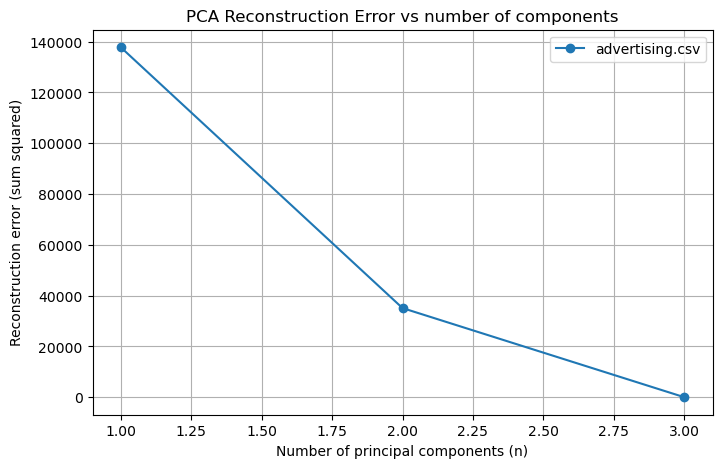

In [17]:
# Cell 5: plot results for visualization
for fname, results in all_results.items():
    ns = []
    errs = []
    for n in sorted(results.keys()):
        if results[n] is None:
            continue
        ns.append(n)
        errs.append(results[n])
    if ns:
        plt.plot(ns, errs, marker='o', label=fname)
plt.xlabel("Number of principal components (n)")
plt.ylabel("Reconstruction error (sum squared)")
plt.title("PCA Reconstruction Error vs number of components")
plt.legend()
plt.grid(True)
plt.show()


# Part 2 — Gradient Descent comparison
We will:
- Use Linear Regression (MSE loss) to predict the last column (target) using other numeric columns.
- Implement:
  1. Simple Gradient Descent (batch)
  2. Momentum-based GD
  3. Nesterov Accelerated Gradient (NAG)
- Measure training loss vs iterations and compare convergence speed.


In [18]:
# Cell 6: GD implementations for linear regression (MSE)
def mse_loss(X, y, w):
    """
    X: (n_samples, n_features)  (already with bias column if used)
    y: (n_samples,)
    w: (n_features,)
    """
    preds = X @ w
    err = preds - y
    return 0.5 * np.mean(err**2)  # 0.5 for convenience in gradient

def grad_mse(X, y, w):
    """
    gradient of 0.5*MSE: (1/n) * X^T (Xw - y)
    """
    n = X.shape[0]
    return (X.T @ (X @ w - y)) / n

def run_simple_gd(X, y, lr=0.01, n_iters=1000):
    w = np.zeros(X.shape[1])
    losses = []
    for i in range(n_iters):
        g = grad_mse(X, y, w)
        w = w - lr * g
        losses.append(mse_loss(X, y, w))
    return w, losses

def run_momentum_gd(X, y, lr=0.01, gamma=0.9, n_iters=1000):
    w = np.zeros(X.shape[1])
    v = np.zeros_like(w)
    losses = []
    for i in range(n_iters):
        g = grad_mse(X, y, w)
        v = gamma * v + lr * g
        w = w - v
        losses.append(mse_loss(X, y, w))
    return w, losses

def run_nesterov_gd(X, y, lr=0.01, gamma=0.9, n_iters=1000):
    w = np.zeros(X.shape[1])
    v = np.zeros_like(w)
    losses = []
    for i in range(n_iters):
        # lookahead position
        w_look = w - gamma * v
        g = grad_mse(X, y, w_look)
        v = gamma * v + lr * g
        w = w - v
        losses.append(mse_loss(X, y, w))
    return w, losses


**Preprocessing for regression**  
- We'll standardize features (zero mean, unit variance) for stable GD.
- Add a bias column (intercept) as the last column of X.
- Use same hyperparameters across methods to compare fairly.


In [20]:
# Cell 7: run GD comparisons on each dataset
gd_results = {}  # store loss curves

for fname in filenames:
    print(f"\nRunning GD comparisons on {fname} ...")
    try:
        df = clean_and_load(fname)
    except FileNotFoundError:
        print(f"{fname} not found. Skipping.")
        continue
    if df.shape[1] < 2:
        print(f"Not enough numeric columns in {fname}. Skipping.")
        continue

    # pick last column as target
    X_raw = df.iloc[:, :-1].values.astype(float)
    y_raw = df.iloc[:, -1].values.astype(float)

    # standardize features
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X_raw)

    # add bias column
    X = np.hstack([X_std, np.ones((X_std.shape[0],1))])  # last column is bias
    y = y_raw.copy()

    # hyperparams (you may tune these)
    lr = 0.05
    gamma = 0.9
    n_iters = 500

    w_s, losses_s = run_simple_gd(X, y, lr=lr, n_iters=n_iters)
    w_m, losses_m = run_momentum_gd(X, y, lr=lr, gamma=gamma, n_iters=n_iters)
    w_n, losses_n = run_nesterov_gd(X, y, lr=lr, gamma=gamma, n_iters=n_iters)

    gd_results[fname] = {
        'simple': losses_s,
        'momentum': losses_m,
        'nesterov': losses_n
    }

    # Print final losses
    print(f"Final losses -> simple: {losses_s[-1]:.4f}, momentum: {losses_m[-1]:.4f}, nesterov: {losses_n[-1]:.4f}")



Running GD comparisons on advertising.csv ...
Final losses -> simple: 1.3530, momentum: 1.3530, nesterov: 1.3530

Running GD comparisons on faa.csv ...
Final losses -> simple: nan, momentum: nan, nesterov: nan

Running GD comparisons on Housing.csv ...
Final losses -> simple: 0.3004, momentum: 0.3004, nesterov: 0.3004


c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


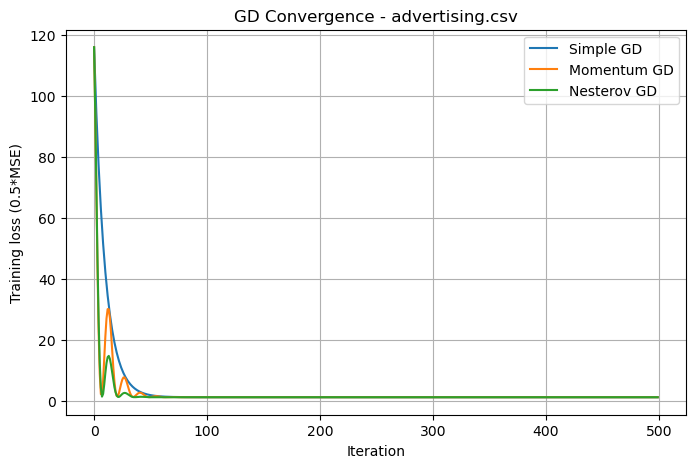

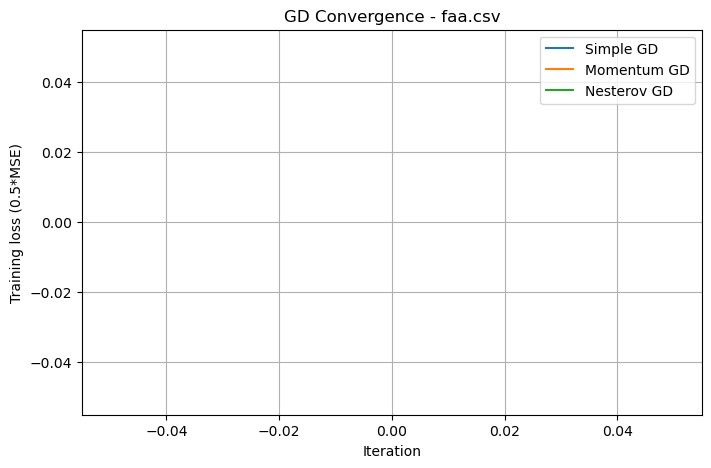

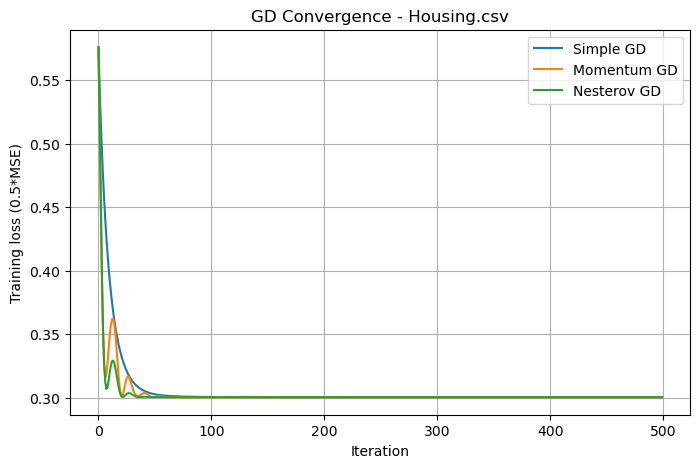

In [13]:
# Cell 8: Plot GD convergence curves for each dataset
for fname, curves in gd_results.items():
    plt.figure()
    plt.plot(curves['simple'], label='Simple GD')
    plt.plot(curves['momentum'], label='Momentum GD')
    plt.plot(curves['nesterov'], label='Nesterov GD')
    plt.xlabel("Iteration")
    plt.ylabel("Training loss (0.5*MSE)")
    plt.title(f"GD Convergence - {fname}")
    plt.legend()
    plt.grid(True)
    plt.show()
